In [3]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'rating_all_zero'):
    # ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return book_vectors, user_vectors

There are 2 types of rating/interaction data:
  
 - `Rating_all_missing_zero`: Numeric values more than 0 indicate the star ratings given. Missing values are replaced with 0's, so that there are no missing ratings. In another word, if a user has not left any reviews for a book, we assume that the user would rate the book 0 star.
 
 - `Rating_interaction_zero`: Numeric values more than 0 indicate the ratings given. Now, we replace missing values with 0's, _only if the user interacted with that book in the past_. In other words, if a user has not left any reviews for a book *and* has interacted with the book, we assume that the user would rate the book 0 star. Note that after such replacement, we would still get some missing values, since not all users have interacted with all the books.

In [4]:
book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')

In [5]:
def get_shapes_and_ranges(book_vectors, item_vectors):
    print(np.shape(book_vectors), np.shape(item_vectors))

In [6]:
get_shapes_and_ranges(book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(book_vectors_interact0, user_vectors_interact0)

(200, 10) (1000, 10)
(200, 10) (1000, 10)


## Part1: Predictions and recommendations with different data types

Generating predictions

In [7]:
def get_predictions(user_vectors, book_vectors):
    book_vectors_transposed = np.transpose(book_vectors)
    predicted_ratings = np.dot(user_vectors, book_vectors_transposed)
    return predicted_ratings

    

In [8]:
def get_first_ten(pre_matrix, type_name):
    print('Ratings for first 10 items, ', type_name)
    np.set_printoptions(precision=3, suppress = True)
    print(pre_matrix[0][0:10])

Output the predictions for first 10 items for the first user, using each of the 2 data types.

In [9]:
all_missing_0_pre_matrix = get_predictions(user_vectors_allmissing0, book_vectors_allmissing0)
in_0_pre_matrix = get_predictions(user_vectors_interact0, book_vectors_interact0)
print(all_missing_0_pre_matrix[0][0:10])
print(in_0_pre_matrix[0][0:10])

[ 0.08031172  0.28975416  0.06345163  1.5695302  -0.18567229  0.05502522
  0.01107722 -0.08822294 -0.89503553 -0.01175208]
[-1.00879311  4.16663033 -0.91856862 -0.30194806 -2.52606751 -0.18905701
 -3.08103904 -0.53718459 -1.18618829 -1.21838417]


Scatterplot the predicted rating for two data types. (Each dot represents one user and one book, with X axis being predicted ratings using `Rating_interaction_zero` data and Y axis being predicted rating using `Rating_all_missing_zero` ratings). 

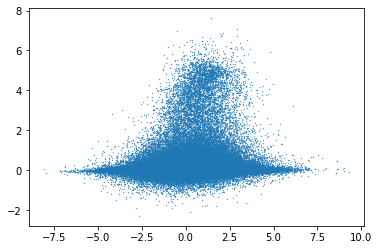

In [10]:
all_missing_0_pre_matrix_vec = all_missing_0_pre_matrix.reshape(1000*200)
in_0_pre_matrix_vec = in_0_pre_matrix.reshape(1000*200)
plt.scatter(in_0_pre_matrix_vec, all_missing_0_pre_matrix_vec, s = 0.1)

From predictions to recommendations (without capacity constraints)

The following function takes in the matrix of predicted ratings for each user and item, and returns a dictionary where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [12]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):
    recommendations = {}
    for user in range(np.shape(predictions)[0]):
        recommendations[user] = list(np.argsort(predictions[user,:])[-number_top_items:])
    
    return recommendations

# Generate the predicted ratings matrices for both data types
predictions_all_missing_zero = get_predictions(user_vectors_allmissing0, book_vectors_allmissing0)
predictions_interaction_zero = get_predictions(user_vectors_interact0, book_vectors_interact0)

# Get the recommendations for both data types
recommendations_all_missing_zero = get_recommendations_for_each_user(predictions_all_missing_zero)
recommendations_interaction_zero = get_recommendations_for_each_user(predictions_interaction_zero)

Output the recommendations for the first user, using each of the 2 data types.

In [13]:
# Assuming recommendations_all_missing_zero and recommendations_interaction_zero are already populated
print("Recommendations for the first user (Rating_all_missing_zero):")
print(recommendations_all_missing_zero[0])

print("\nRecommendations for the first user (Rating_interaction_zero):")
print(recommendations_interaction_zero[0])


Recommendations for the first user (Rating_all_missing_zero):
[96, 77, 86, 58, 78, 50, 81, 56, 55, 57]

Recommendations for the first user (Rating_interaction_zero):
[52, 73, 37, 182, 74, 170, 111, 1, 53, 166]


The following function takes in the (top 10) recommendations for each user, and outputs a histogram for how often each item is to be recommended.

In [25]:
from collections import Counter
def show_frequency_histograms(recommendation):
    recommendations_flattened = np.ndarray.flatten(np.array([list(x) for x in recommendation.values()]))
    counts = list(dict(Counter(recommendations_flattened)).values())
    counts.extend([0 for _ in range(200-len(counts))])
    
    plt.xlabel('Number of items recommended', size = 10)
    plt.ylabel('Number of items in bin', size = 10)
    plt.hist(counts, bins = 50)
    plt.yscale('log')
    sns.despine()
    plt.show()

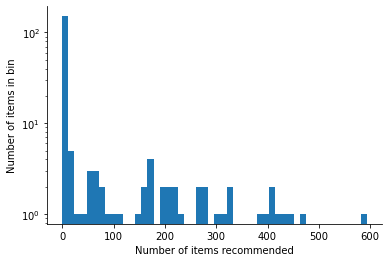

In [26]:
show_frequency_histograms(recommendations_all_missing_zero)

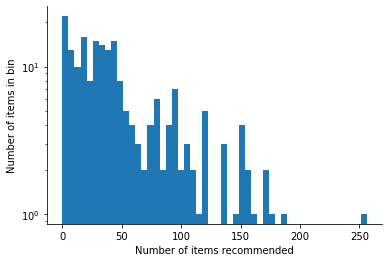

In [27]:
show_frequency_histograms(recommendations_interaction_zero)

# Part 2: Cold start -- recommendations for new users

In this part of the project, we are going to tackle the "cold-start" problem with matrix-factorization based recommendation systems. 

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [28]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the `Rating_interaction_zero` data.

In [29]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

###  Predictions for new users 

The following function takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
 We are going to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of about 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The correpsonding mean vector is then used for each new user. 

In [30]:
existing_user_demographics.Wealth.median()

1.7026180771992308

In [31]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    median_wealth = existing_user_demographics.Wealth.median()
    
    # Categorize existing users as either "Low" or "High" wealth
    existing_user_demographics['Wealth_category'] = existing_user_demographics['Wealth'].apply(lambda x: 'Low' if x < median_wealth else 'High')
    
    # Calculate the mean vectors for both "Low" and "High" wealth categories
    low_wealth_users = existing_user_demographics[existing_user_demographics['Wealth_category'] == 'Low']
    high_wealth_users = existing_user_demographics[existing_user_demographics['Wealth_category'] == 'High']
    
    low_wealth_mean_vector = existing_user_vectors[low_wealth_users.index].mean(axis=0)
    high_wealth_mean_vector = existing_user_vectors[high_wealth_users.index].mean(axis=0)
    
    # Determine the wealth category of the new user and return the corresponding mean vector
    if new_user.Wealth.values[0] < median_wealth:
        return low_wealth_mean_vector
    else:
        return high_wealth_mean_vector


Output the mean vector predicted for the first user (index 0) in `new_user_demographics`. 

In [32]:
# Get the mean vector for the first user in new_user_demographics
first_user = new_user_demographics.iloc[0:1, :]
predicted_vector = get_user_vector_for_new_user(first_user, existing_user_demographics, existing_user_vectors)
print(predicted_vector)

[ 0.08780943 -0.20709913 -0.17762736 -0.13094589 -0.08942902 -0.12702042
 -0.12242308 -0.42681059 -0.05775285 -0.1056909 ]


/var/folders/r4/l54jdjtx3ms0b_p6yqw0sj9c0000gn/T/ipykernel_77810/2246581501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  existing_user_demographics['Wealth_category'] = existing_user_demographics['Wealth'].apply(lambda x: 'Low' if x < median_wealth else 'High')


Plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Part 1. Each point in the scatter plot should correspond to one user and one item. 

/var/folders/r4/l54jdjtx3ms0b_p6yqw0sj9c0000gn/T/ipykernel_77810/2246581501.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  existing_user_demographics['Wealth_category'] = existing_user_demographics['Wealth'].apply(lambda x: 'Low' if x < median_wealth else 'High')


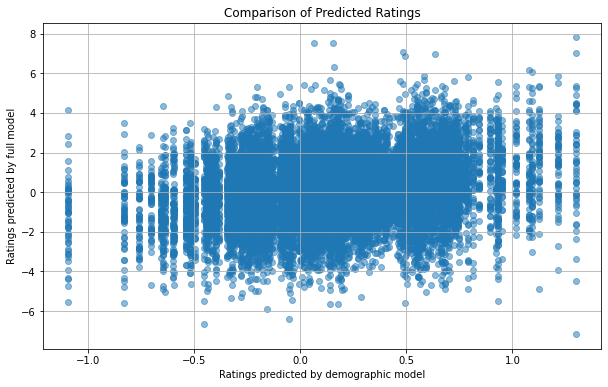

In [34]:
demographic_predicted_ratings = []
full_model_predicted_ratings = []

for index, new_user in new_user_demographics.iterrows():
    new_user_vector = get_user_vector_for_new_user(new_user.to_frame().transpose(), existing_user_demographics, existing_user_vectors)
    
    demographic_predictions = get_predictions(new_user_vector.reshape(1, -1), book_vectors_interact0)
    full_model_predictions = get_predictions(user_vectors_interact0[index].reshape(1, -1), book_vectors_interact0)
    
    demographic_predicted_ratings.extend(demographic_predictions.flatten())
    full_model_predicted_ratings.extend(full_model_predictions.flatten())

plt.figure(figsize=(10, 6))
plt.scatter(demographic_predicted_ratings, full_model_predicted_ratings, alpha=0.5)
plt.xlabel('Ratings predicted by demographic model')
plt.ylabel('Ratings predicted by full model')
plt.title('Comparison of Predicted Ratings')
plt.grid(True)
plt.show()


# Part 3: Predictions under capacity constraints

For this part, we are going to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

### Naive recommendations under capacity constraints

In [35]:
item_cap = [5 for _ in range(200)]
rec_items = []
rank_rec = []
for user in range(1000):
    pre_order = reversed(np.argsort(in_0_pre_matrix[user,:]))
    for rank, item in enumerate(pre_order):
        if item_cap[item]>0:
            item_cap[item] -= 1
            rec_items.append(item)
            rank_rec.append(rank)
            break
rank_rec[0],rank_rec[-1]

(0, 128)

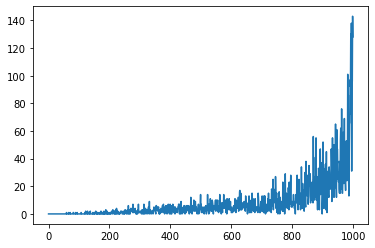

In [36]:
plt.plot(rank_rec)

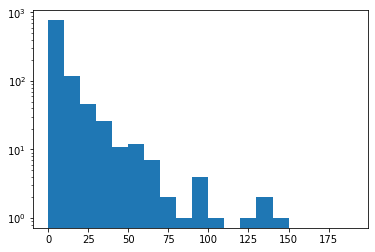

In [41]:
plt.hist(rank_rec, bins = range(0,200,10))
plt.yscale('log')

### Score functions for recommendations under capacity constraints

<font color='blue'> For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{j}}} \sqrt{C_j} $$



In [47]:
pre_matrix_nor = in_0_pre_matrix - np.min(in_0_pre_matrix)
pre_matrix_nor = pre_matrix_nor/np.max(pre_matrix_nor)
mean_item_ratings= np.mean(pre_matrix_nor, axis = 0)
item_cap = [5 for _ in range(200)]
rec_items = []
rank_rec_score = []
for user in range(1000):
    rij = in_0_pre_matrix[user,:]
    true_pre_order = list(reversed(np.argsort(rij)))
    sij = [rij[item]/mean_item_ratings[item]*np.sqrt(item_cap[item]) for item in enumerate(rec_items)]
    pre_order = reversed(np.argsort(sij))
    for _, item in enumerate(pre_order):
        if item_cap > 0:
            item_cap[item] -= 1
            rec_items.append(item)
            rank = true_pre_order.index(item)
            rank_rec_score.append(rank)
            break
    

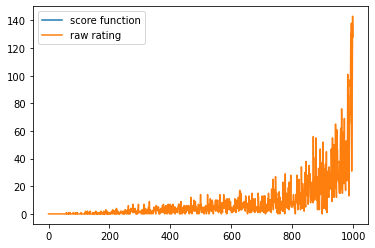

In [51]:
plt.plot(rank_rec_score, label = 'score function', alpha = 1) 
plt.plot(rank_rec, label = 'raw rating', alpha = 1) 
plt.legend()

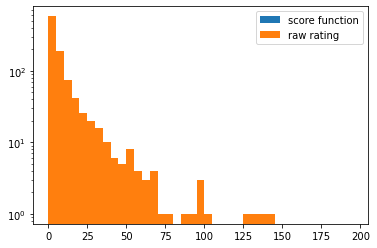

In [50]:
plt.hist(rank_rec_score, bins = range(0, 200, 5), label = 'score function')
plt.hist(rank_rec, bins = range(0, 200, 5), label = 'raw rating', alpha = 1)
plt.legend()
plt.yscale('log')